In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats as sps
from matplotlib import pyplot as plt
from math import factorial as fact

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = 12, 7
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 16

SEED = 42
np.random.seed(seed=SEED)

## Задача 1

ПОдготовка данных

In [227]:
p1 = 0.9
p2 = 0.5
p0 = 1e-4
k_arr = np.array([1] + list(range(10, 1001, 10)))
k_people = 100
k_repeats = 20000

oracles_cnt_distr = sps.binom(k_people, p0)
n_oracles = oracles_cnt_distr.rvs(size=(k_arr.size, k_repeats), 
                                  random_state=SEED)
aprior_oracle_proba = np.zeros(k_arr.size)

Получение априорной вероятности выбора оракула

In [228]:
for i, k in enumerate(k_arr):
    orcl_successes_distr = sps.binom(k, p1)
    comm_successes_distr = sps.binom(k, p2)

    inds_with_oracles = np.flatnonzero(n_oracles[i])
    
    for j in inds_with_oracles:
        k_oracles = n_oracles[i, j]
        k_commoners = K_people - k_oracles
        
        oracles_results = orcl_successes_distr.rvs(k_oracles)
        commoners_results = comm_successes_distr.rvs(k_commoners)
        
        orcl_max_success_cnt = oracles_results.max()
        comm_max_success_cnt = commoners_results.max()
        
        if orcl_max_success_cnt > comm_max_success_cnt:
            aprior_oracle_proba[i] += 1
        elif orcl_max_success_cnt == comm_max_success_cnt:
            k_best_oracles = np.sum(oracles_results == orcl_max_success_cnt)
            k_best_commoners = np.sum(commoners_results == comm_max_success_cnt)
            
            aprior_oracle_proba[i] += k_best_oracles / (k_best_oracles+k_best_commoners)
            
    aprior_oracle_proba[i] /= k_repeats

Отрисовка графика априорной вероятности для различных k

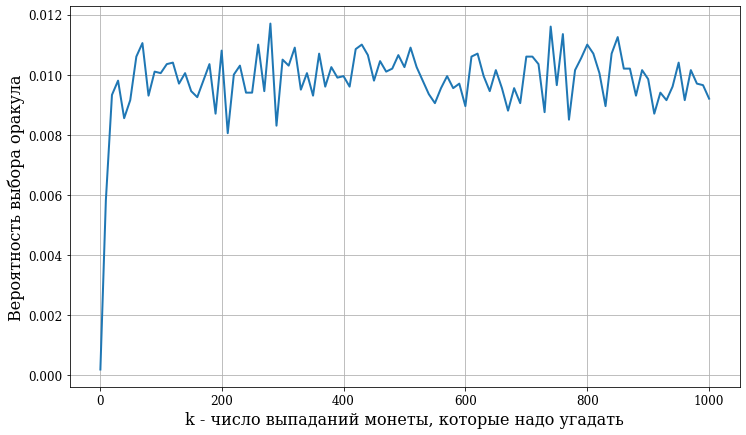

In [230]:
plt.plot(k_arr, aprior_oracle_proba)
plt.xlabel('k - число выпаданий монеты, которые надо угадать')
plt.ylabel('Вероятность выбора оракула')
plt.grid(True)
plt.show()

## Задача 3

Создаём распределения с задаными параметрами

In [3]:
norm_independ_distr = sps.multivariate_normal(mean=[0, 0], 
                                              cov=[[1, 0], [0, 1]], 
                                              allow_singular=True)
norm_correl_distr = sps.multivariate_normal(mean=[0, 0], 
                                            cov=[[1, 0.5], [0.5, 1]], 
                                            allow_singular=True)
n = 100 # sample size
N = 2000 # number of samples

Отрисовка функций плотности и гистограммы для $\rho = 0$

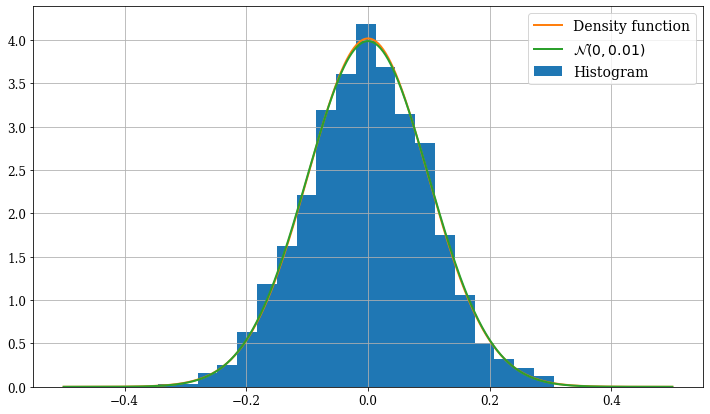

In [4]:
def pdf_0(x, rho=0, n=n):
    scalar = np.exp(n/2*np.log(n/2)- scipy.special.gammaln(n/2))
    beta = n / (1 - rho)
    gamma = n / (1 + rho)
    
    abs_x = np.abs(x)
    x_part = np.power(abs_x, n/2-1) * np.sqrt((beta+gamma)*abs_x/np.pi)
    x_part *= np.exp(x/2*(beta-gamma))
    
    bessel_part = scipy.special.kv((1-n)/2, (beta+gamma)*abs_x/2)
    
    return scalar * x_part * bessel_part
    
hist = norm_independ_distr.rvs(size=(N, n), random_state=SEED)
hist = np.mean(np.prod(hist, axis=-1), axis=-1)

ticks = np.linspace(-0.5, 0.5, 500)
pdf_0_values = pdf_0(ticks)

plt.hist(hist, bins=20, label='Histogram', density=True)
plt.plot(ticks, pdf_0_values, label='Density function')
plt.plot(ticks, sps.norm(0, 0.1).pdf(ticks), label='$\mathcal{N}(0, 0.01)$')
plt.grid(True)
plt.legend()
plt.show()

Отрисовка функций плотности и гистограммы для $\rho = 0.5$

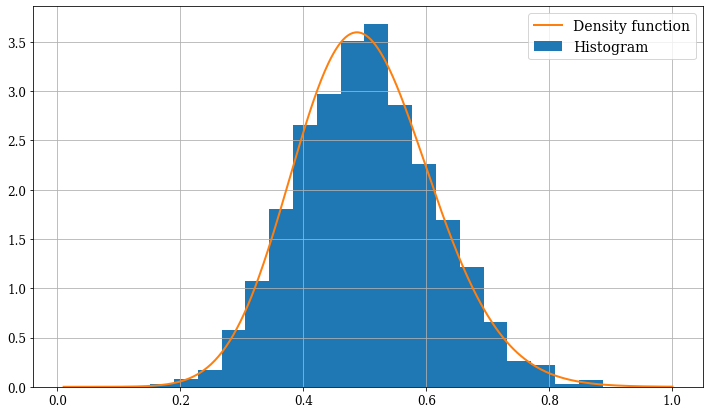

In [5]:
hist = norm_correl_distr.rvs(size=(N, n), random_state=SEED)
hist = np.mean(np.prod(hist, axis=-1), axis=-1)

ticks = np.linspace(0.01, 1, 500)
pdf_0_values = pdf_0(ticks, rho=0.5)

plt.hist(hist, bins=20, label='Histogram', density=True)
plt.plot(ticks, pdf_0_values, label='Density function')
plt.grid(True)
plt.legend()
plt.show()

Сравнение распределений статистики $T(Z)$ при $\rho = 0$ и $\mathcal{N}(0, \frac1n)$

<u>Замечание</u> При $n \geqslant 300$ возникают артефакты из-за вычислительной нестабильности

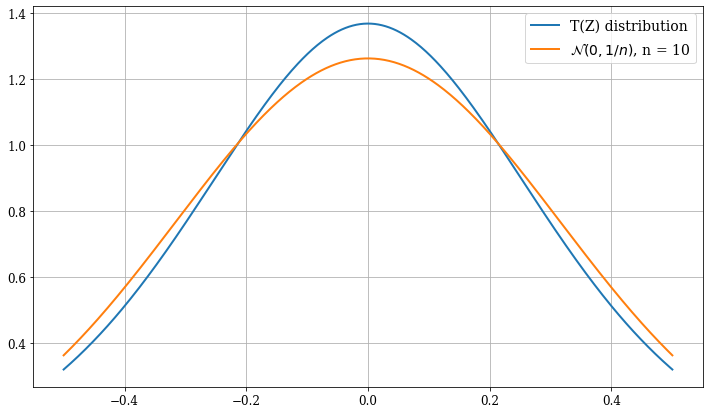

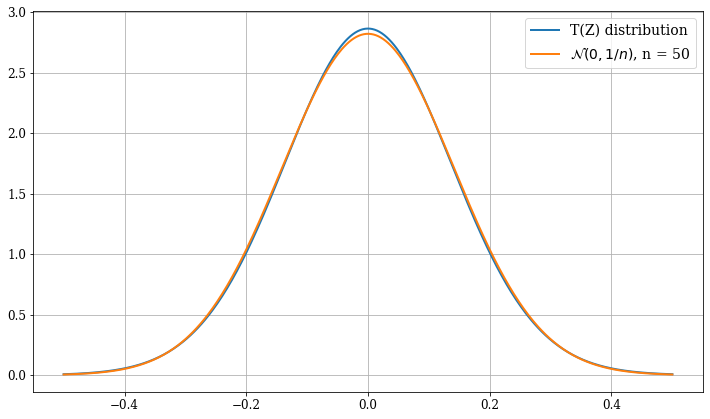

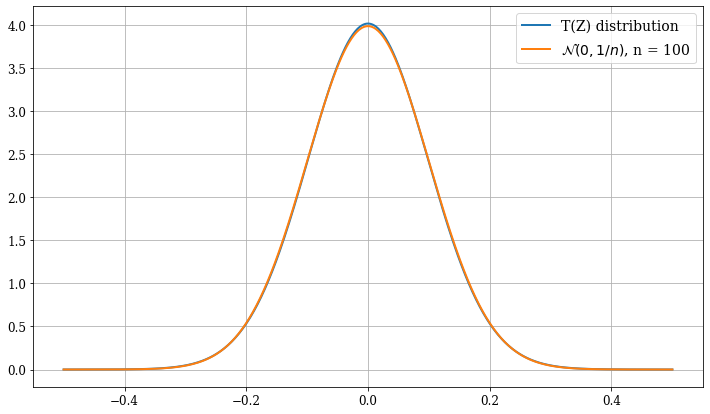

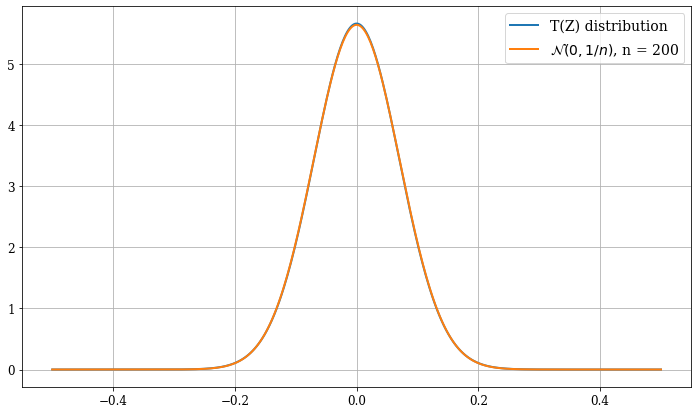

/tmp/ipykernel_102064/1743054744.py:12: RuntimeWarning: invalid value encountered in multiply
  return scalar * x_part * bessel_part


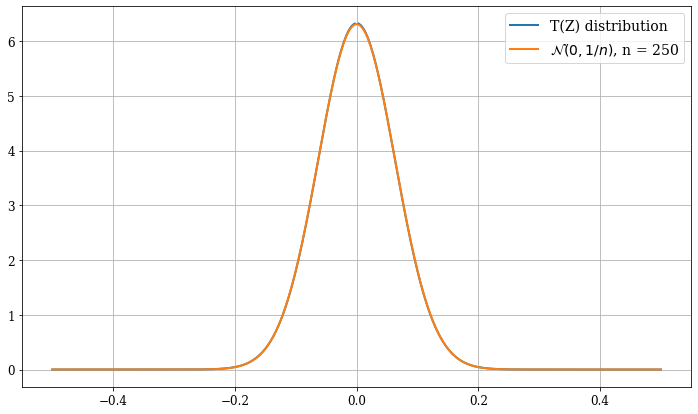

/tmp/ipykernel_102064/1743054744.py:12: RuntimeWarning: invalid value encountered in multiply
  return scalar * x_part * bessel_part


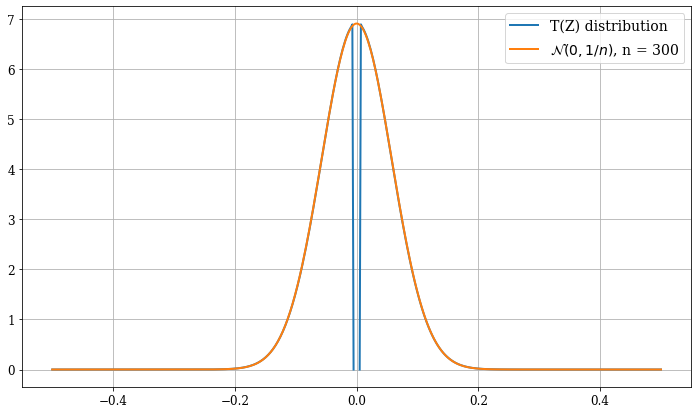

/tmp/ipykernel_102064/1743054744.py:12: RuntimeWarning: invalid value encountered in multiply
  return scalar * x_part * bessel_part


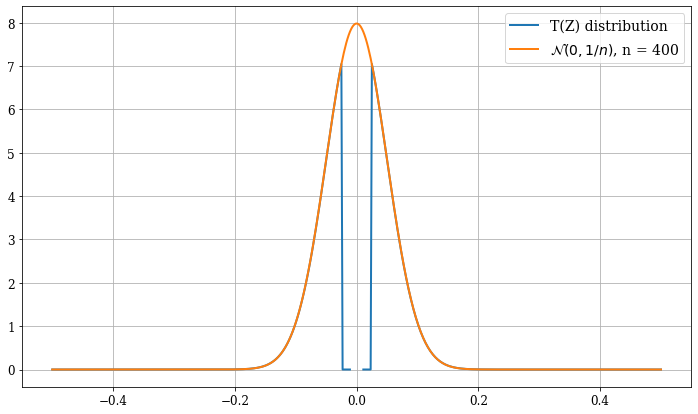

In [238]:
for temp_n in (10, 50, 100, 200, 250, 300, 400):
    ticks = np.linspace(-0.5, 0.5, 500)
    pdf_0_values = pdf_0(ticks, n=temp_n)
    norm_values = sps.norm(0, np.sqrt(1/temp_n)).pdf(ticks)
    
    plt.figure()
    plt.plot(ticks, pdf_0_values, label='T(Z) distribution')
    plt.plot(ticks, norm_values, label='$\mathcal{N}(0, 1/n)$, n = %d' % temp_n)
    plt.grid(True)
    plt.legend()
    plt.show()

**Вывод:** Распределение статистики T(Z) стремится к $\mathcal{N}(0, \frac1n)$ по распределению при верности $H_0$

#### Зависимость мощности критерия от $n \text{ и } \rho$

In [107]:
alpha = 0.05 # заданный уровень значимости
threshold = sps.norm(0, 1/n**0.5).ppf(1-alpha/2)

rhos = list(np.arange(-0.9, -0.4, 0.1)) + list(np.arange(-0.4, 0.4, 0.05))
rhos += list(np.arange(0.4, 0.91, 0.1))
powers = np.zeros_like(rhos)
repeats_count = 50
eps = 1e-6

for i, rho in enumerate(rhos):
    if -eps < rho < eps:
        continue
        
    distr = sps.multivariate_normal(mean=[0, 0], 
                                    cov=[[1, rho], [rho, 1]], 
                                    allow_singular=True)

    sample = distr.rvs(size=(repeats_count, N, n), random_state=SEED)
    tz_stat = np.mean(np.prod(sample, axis=-1), axis=-1)                                            

    criterion_power = np.sum(np.abs(tz_stat) > threshold, axis=-1)
    powers[i] = criterion_power.mean()
    
powers /= N

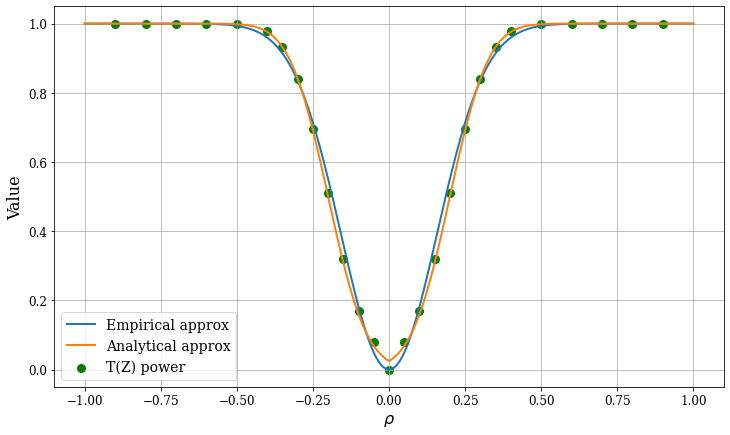

In [110]:
def empirical_approx(rho):
    return 1 - np.exp(-rho**2/0.05)


def analytical_approx(rho, n):
    rho = np.abs(rho)
    x = (threshold-rho) * np.sqrt(n/(1+rho**2))
    return 1 - sps.norm().cdf(np.tanh(0.2-rho)*n**0.5)

ticks = np.linspace(-1, 1, 500)

plt.plot(ticks, empirical_approx(ticks), label='Empirical approx')
plt.plot(ticks, analytical_approx(ticks, n), label='Analytical approx')
plt.scatter(rhos, powers, label='T(Z) power', c='green')

plt.xlabel('$\\rho$')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

**Вывод**: Функция мощности критерия хорошо приближается функцией $1 - \exp \left(-\dfrac{\rho^2}{0.05}\right)$ при $n = 100$

Графики распределений T(Z) при различных $\rho \text{ и } n$

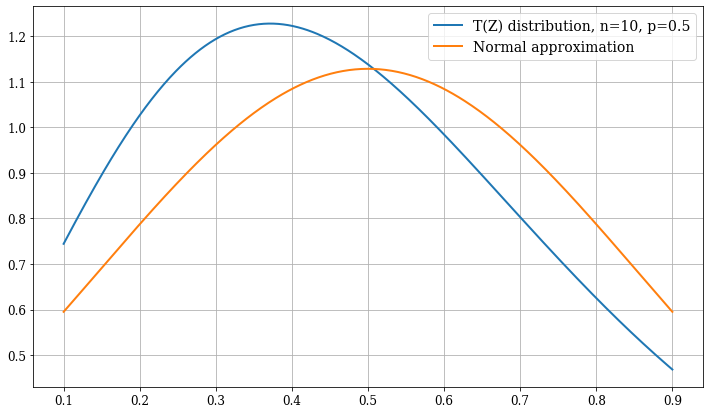

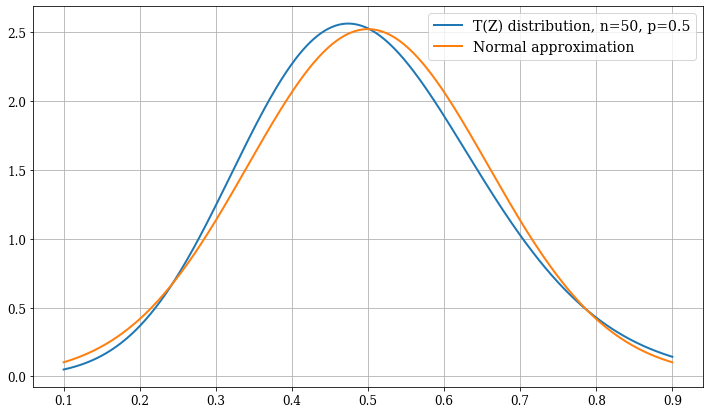

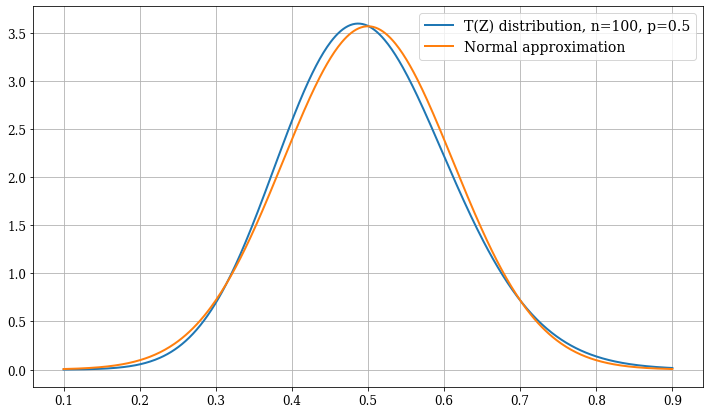

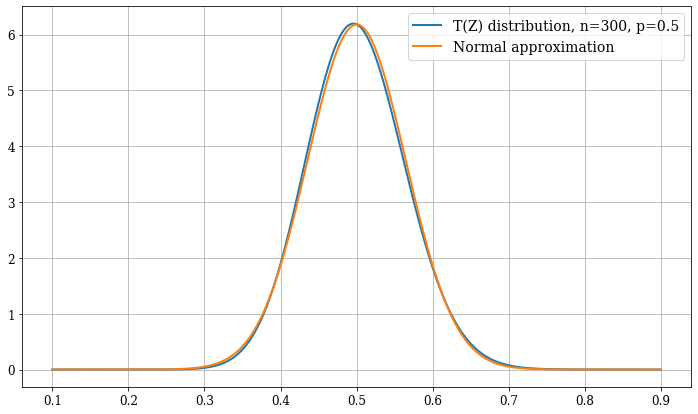

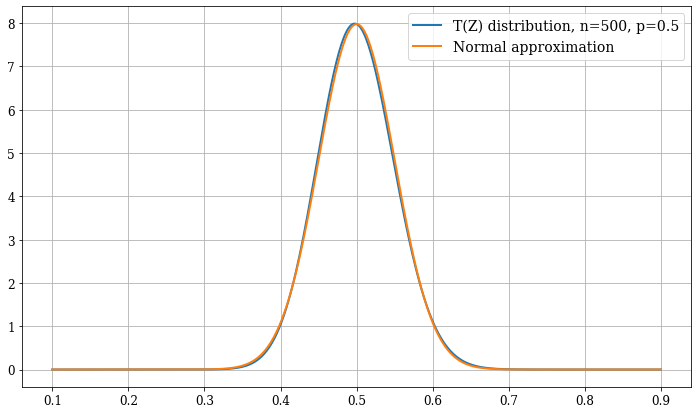

In [84]:
rho = 0.5
ticks = np.linspace(-0.4+rho, 0.4+rho, 500)

for temp_n in (10, 50, 100, 300, 500):
    pdf_0_values = pdf_0(ticks, rho=rho, n=temp_n)
    normal_values = sps.norm(rho, ((1+rho**2)/temp_n)**0.5).pdf(ticks)
    
    plt.figure()
    plt.plot(ticks, pdf_0_values, label=f'T(Z) distribution, n={temp_n}, p={rho}')
    plt.plot(ticks, normal_values, label='Normal approximation')
    plt.grid(True)
    plt.legend()
    plt.show()

**Вывод** Аппроксимация $T(Z)$ нормальным распределением точна при больших $n$ (n >= 300)

### Мощность $U(Z) = \dfrac{1}{2n} \sum\limits_{i=1}^n (x_i - y_i)^2$

In [116]:
alpha = 0.05 # заданный уровень значимости
threshold = sps.gamma(a=n/2, scale=2/n).ppf(1-alpha)

u_powers = np.zeros_like(rhos)
repeats_count = 50

for i, rho in enumerate(rhos):
    if -eps < rho < eps:
        continue
        
    distr = sps.multivariate_normal(mean=[0, 0], 
                                    cov=[[1, rho], [rho, 1]], 
                                    allow_singular=True)

    sample = distr.rvs(size=(repeats_count, N, n), random_state=SEED)
    sample[:, :, :, -1] *= -1
    uz_stat = np.mean(np.square(np.sum(sample, axis=-1)), axis=-1) / 2                                            

    criterion_power = np.sum(uz_stat > threshold, axis=-1)
    u_powers[i] = criterion_power.mean()
    
u_powers /= N

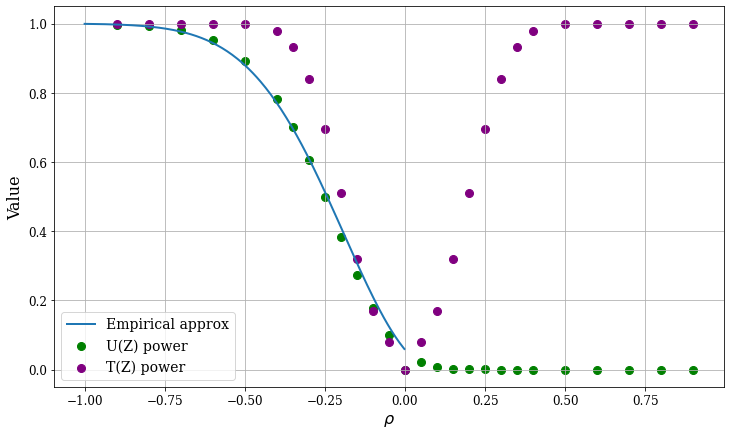

In [174]:
ticks = np.linspace(-1, 1, 500)
neg_ticks = ticks[ticks < 0]

plt.plot(neg_ticks, 1 - np.exp(-(neg_ticks-0.1)**2/0.17), label='Empirical approx')
plt.scatter(rhos, u_powers, label='U(Z) power', c='green')
plt.scatter(rhos, powers, label='T(Z) power', c='purple')

plt.xlabel('$\\rho$')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

**Вывод:** 
1. Функция мощности критерия $U(Z)$ хорошо приближается функцией $1 - \exp \left(-\dfrac{(\rho - 0.1)^2}{0.17}\right)$ при $n = 100$  

2. Эмпирически убедились в том, что критерий $T(Z)$ мощнее критерия $U(Z)$ для любого $\rho$

## Рисунок к задаче 4

Получение данных

In [246]:
t_distr = sps.t(10)
rho_arr = np.arange(0, 1, 0.01)
t_stat_lower_bounds = rho_arr * 10**0.5 / (1 - rho_arr**2)**0.5

probs = 1 - t_distr.cdf(t_stat_lower_bounds)
k_values = 1 / probs

Отрисовка

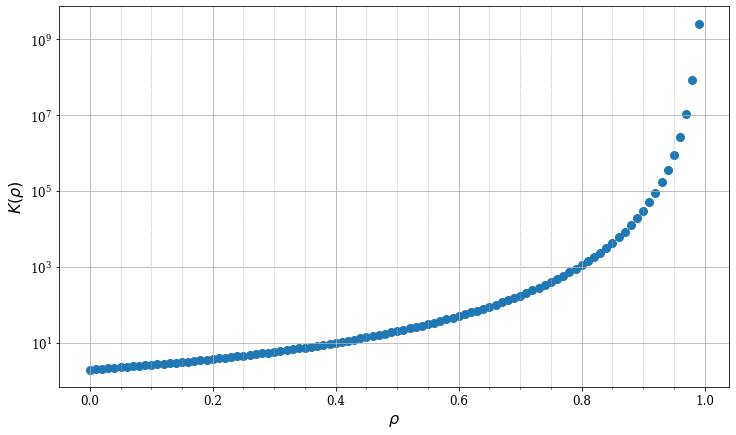

In [247]:
plt.figure(figsize=(12, 7))
plt.scatter(rho_arr, k_values)
plt.xlabel(r'$\rho$')
plt.ylabel(r'$K(\rho)$')
plt.yscale('log')
plt.grid(True, which='major')
plt.minorticks_on()
plt.grid(True, which='minor', linestyle='--', linewidth = 0.5)
plt.show()

Получим зависимость между $\rho$ и $K(\rho)$ сэмплированием

In [248]:
m = 10 # Число повторений эксперимента
n = 12 # Размер выборки
rhos_count = 90
big_sample_size = int(1e6)
empirical_k_values = np.zeros(rhos_count)
norm_distr = sps.norm()

for j in range(m):
    x = norm_distr.rvs(size=n)
    y = norm_distr.rvs(size=(big_sample_size, n))
    
    corr = [np.corrcoef(x, y[i])[0, 1] for i in range(big_sample_size)]
    corr = np.array(corr)
    
    for i in range(rhos_count):
        rho = i / 100
        k_value = np.argmax(corr >= rho) + 1
        
        if k_value == 1 and corr[0] < rho:
            k_value = big_sample_size
            
        empirical_k_values[i] += k_value / m
        
    print(f'Experiment {j + 1} is finished!')

Experiment 1 is finished!
Experiment 2 is finished!
Experiment 3 is finished!
Experiment 4 is finished!
Experiment 5 is finished!
Experiment 6 is finished!
Experiment 7 is finished!
Experiment 8 is finished!
Experiment 9 is finished!
Experiment 10 is finished!


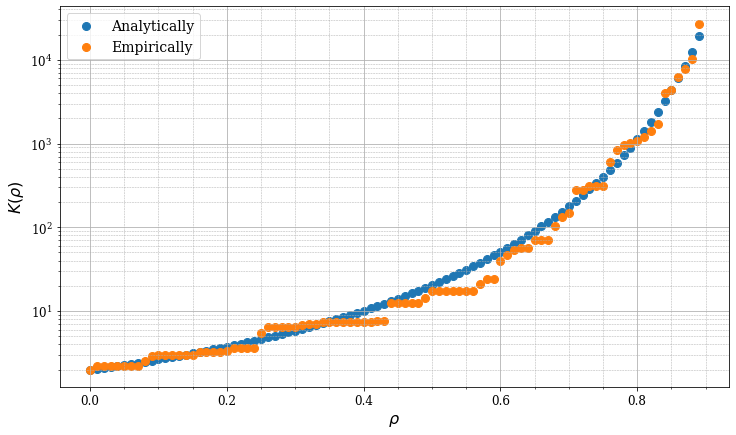

In [249]:
plt.figure(figsize=(12, 7))
plt.scatter(rho_arr[:rhos_count], 
            k_values[:rhos_count], 
            label="Analytically")
plt.scatter(rho_arr[:rhos_count], 
            empirical_k_values[:rhos_count], 
            label="Empirically")
plt.xlabel(r'$\rho$')
plt.ylabel(r'$K(\rho)$')
plt.yscale('log')
plt.grid(True, which='major')
plt.minorticks_on()
plt.grid(True, which='minor', linestyle='--', linewidth = 0.5)
plt.legend()
plt.show()

## Задача 6

### Первый пункт

Сэмплируем выборки из условия задачи

In [5]:
norm_independ_distr = sps.multivariate_normal(mean=[0, 0], 
                                              cov=[[1, 0], [0, 1]], 
                                              allow_singular=True)
norm_correl_distr = sps.multivariate_normal(mean=[0, 0], 
                                            cov=[[1, 0.2], [0.2, 1]], 
                                            allow_singular=True)
n = 100 # sample size
N = 500 # number of samples
alpha = 0.05 # confidence level

independ_sample = norm_independ_distr.rvs(size=(N, n), random_state=SEED)
corr_sample = norm_correl_distr.rvs(size=(N, n), random_state=SEED)

Получение достигаемых уровней значимости с использованием статистики T(Z) из задачи 3

Критерий имеет вид: $\{ |T(Z)| > u_{\frac{1-\alpha}{2}} \}$

In [50]:
tz_stat_distr = sps.norm(0, 1/n**0.5)
independ_tz_stat = np.mean(np.prod(independ_sample, axis=-1), axis=-1)
corr_tz_stat = np.mean(np.prod(corr_sample, axis=-1), axis=-1)

independ_p_values = 2*tz_stat_distr.cdf(-np.abs(independ_tz_stat))
corr_p_values = 2*tz_stat_distr.cdf(-np.abs(corr_tz_stat))


Отрисовка полученных p-value

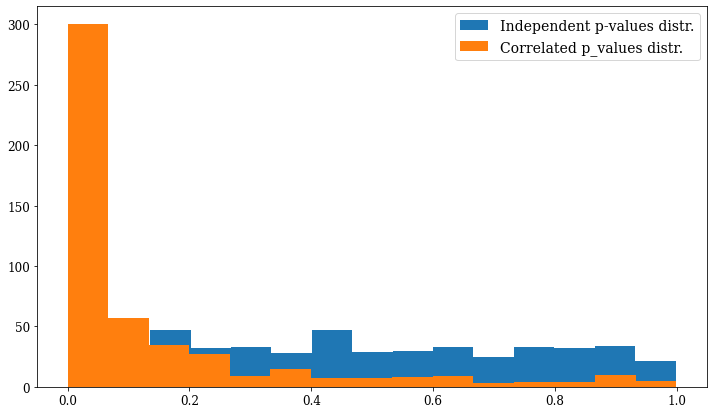

In [51]:
plt.hist(independ_p_values, bins=15, label='Independent p-values distr.')
plt.hist(corr_p_values, bins=15, label='Correlated p_values distr.')
plt.legend()
plt.show()

**Confusion matrix для полученных p-values**

In [52]:
def print_table_of_errors(true_conf_lvl, false_conf_lvl, 
                          true_hyp_p_values, false_hyp_p_values):
    TP = np.sum(true_hyp_p_values >= true_conf_lvl)
    TN = np.sum(false_hyp_p_values < false_conf_lvl)
    FN = np.sum(true_hyp_p_values < true_conf_lvl)
    FP = np.sum(false_hyp_p_values >= false_conf_lvl)
    
    format_str = '{:<16} | {:<12} | {:<12} | {:<8}'
    print(format_str.format(' ', 'H0 - верна', 'H0 - ложна', 'Всего'))
    print('-' * 57)
    print(format_str.format('# принятых H0', TP, FP, TP+FP))
    print('-' * 57)
    print(format_str.format('# отвергнутых H0', FN, TN, FN+TN))
    print('-' * 57)
    print(format_str.format('Всего', TP+FN, FP+TN, TP+FP+FN+TN))

    
print_table_of_errors(alpha, alpha, independ_p_values, corr_p_values)

                 | H0 - верна   | H0 - ложна   | Всего   
---------------------------------------------------------
# принятых H0    | 467          | 224          | 691     
---------------------------------------------------------
# отвергнутых H0 | 33           | 276          | 309     
---------------------------------------------------------
Всего            | 500          | 500          | 1000    


**Confusion matrix для p-values, к которым была применена поправка Бонферрони**

In [53]:
adj_indep_p_values = np.clip(independ_p_values*2*N, a_min=0, a_max=1)
adj_corr_p_values = np.clip(corr_p_values*2*N, a_min=0, a_max=1)

print_table_of_errors(alpha, alpha, adj_indep_p_values, adj_corr_p_values)

                 | H0 - верна   | H0 - ложна   | Всего   
---------------------------------------------------------
# принятых H0    | 500          | 486          | 986     
---------------------------------------------------------
# отвергнутых H0 | 0            | 14           | 14      
---------------------------------------------------------
Всего            | 500          | 500          | 1000    


**График и confusion matrix для p-values, к которым была применена поправка Бенджамини-Хохберга**

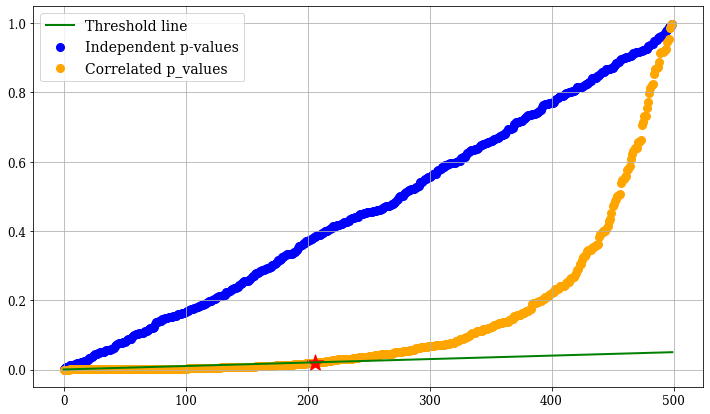

In [59]:
def thr_line_equation(alpha, hyp_count):
    return np.linspace(alpha/hyp_count, alpha, hyp_count)


sort_indep_p_values = np.sort(independ_p_values)
sort_corr_p_values = np.sort(corr_p_values)

ticks = np.arange(N)
thr_line = thr_line_equation(alpha, N)

indep_max_thr_ind = -1 if np.all(sort_indep_p_values >= thr_line) \
                    else np.flatnonzero(sort_indep_p_values < thr_line).max()
corr_max_thr_ind = -1 if np.all(sort_corr_p_values >= thr_line) \
                    else np.flatnonzero(sort_corr_p_values < thr_line).max()

plt.scatter(range(N), sort_indep_p_values, c='blue', label='Independent p-values')
plt.scatter(range(N), sort_corr_p_values, c='orange', label='Correlated p_values')
plt.plot(ticks, thr_line, color='green', label='Threshold line')

adjusted_indep_thr = 0 if indep_max_thr_ind == -1 \
                        else thr_line[indep_max_thr_ind]
adjusted_corr_thr = 0 if thr_line[corr_max_thr_ind] == -1 \
                        else thr_line[corr_max_thr_ind]

if indep_max_thr_ind != -1:
    plt.scatter(x=indep_max_thr_ind, 
                y=sort_indep_p_values[indep_max_thr_ind], 
                c='red', 
                marker='*')
    
if corr_max_thr_ind != -1:
    plt.scatter(x=corr_max_thr_ind, 
                y=sort_corr_p_values[corr_max_thr_ind], 
                s=300,
                c='red', 
                marker='*')

# plt.ylim(0, alpha)
plt.grid(True)
plt.legend()
plt.show()

In [55]:
print_table_of_errors(adjusted_indep_thr, adjusted_corr_thr, 
                      independ_p_values, corr_p_values)

                 | H0 - верна   | H0 - ложна   | Всего   
---------------------------------------------------------
# принятых H0    | 500          | 293          | 793     
---------------------------------------------------------
# отвергнутых H0 | 0            | 207          | 207     
---------------------------------------------------------
Всего            | 500          | 500          | 1000    


**Вывод:**  
1. Поправка Бонферрони уменьшает FWER засчёт увеличения p-values, то есть уменьшения уровня значимости, по которому отвергается гипотеза о независимости.
2. Поправка Бенджамини-Хохберга уменьшает FDR за счёт того, что p-values у тех статистик, для которых верна H0, имеет равномерное распределение на [0; 1], и соответственно коэффициент наклона прямой, аппроксимирующей p-values, будет выше, чем у threshold-прямой

### Второй пункт

Получение p-values

In [17]:
N_ind = 1000 # number of standard normal samples
independ_sample = norm_independ_distr.rvs(size=(N_ind, n), random_state=SEED)

tz_stat_distr = sps.norm(0, 1/n**0.5)
independ_tz_stat = np.mean(np.prod(independ_sample, axis=-1), axis=-1)
independ_p_values = 2*tz_stat_distr.cdf(-np.abs(independ_tz_stat))

Отрисовка p-values

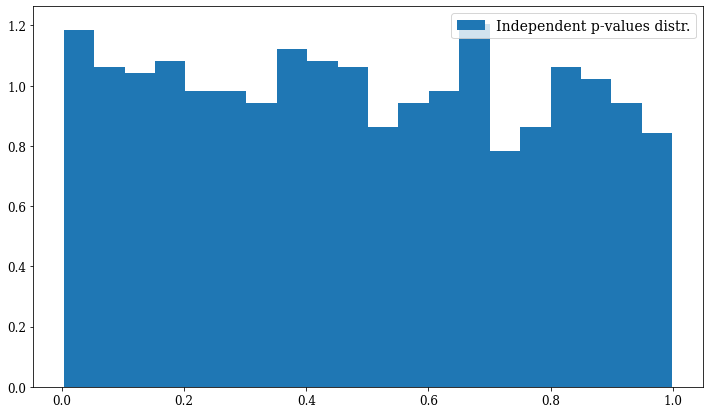

In [18]:
plt.hist(independ_p_values, 
         bins=20, 
         density=True,
         label='Independent p-values distr.')
plt.legend()
plt.show()

**Confusion matrix для полученных p-values**

In [14]:
print_table_of_errors(alpha, alpha, independ_p_values, np.array([]))

                 | H0 - верна   | H0 - ложна   | Всего   
---------------------------------------------------------
# принятых H0    | 942          | 0            | 942     
---------------------------------------------------------
# отвергнутых H0 | 58           | 0            | 58      
---------------------------------------------------------
Всего            | 1000         | 0            | 1000    


**Confusion matrix для p-values, к которым была применена поправка Бонферрони**

In [16]:
adj_indep_p_values = np.clip(independ_p_values*2*N_ind, a_min=0, a_max=1)
print_table_of_errors(alpha, alpha, adj_indep_p_values, np.array([]))

                 | H0 - верна   | H0 - ложна   | Всего   
---------------------------------------------------------
# принятых H0    | 1000         | 0            | 1000    
---------------------------------------------------------
# отвергнутых H0 | 0            | 0            | 0       
---------------------------------------------------------
Всего            | 1000         | 0            | 1000    


**График и confusion matrix для p-values, к которым была применена поправка Бенджамини-Хохберга**

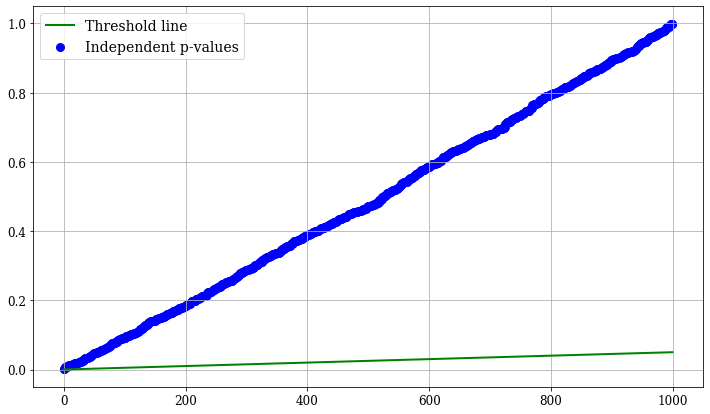

In [21]:
def thr_line_equation(alpha, hyp_count):
    return np.linspace(alpha/hyp_count, alpha, hyp_count)


sort_indep_p_values = np.sort(independ_p_values)

ticks = np.arange(N_ind)
thr_line = thr_line_equation(alpha, N_ind)

indep_max_thr_ind = -1 if np.all(sort_indep_p_values >= thr_line) \
                    else np.flatnonzero(sort_indep_p_values < thr_line).max()

plt.scatter(range(N_ind), sort_indep_p_values, c='blue', label='Independent p-values')
plt.plot(ticks, thr_line, color='green', label='Threshold line')

adjusted_indep_thr = 0 if indep_max_thr_ind == -1 \
                        else thr_line[indep_max_thr_ind]

if indep_max_thr_ind != -1:
    plt.scatter(x=indep_max_thr_ind, 
                y=sort_indep_p_values[indep_max_thr_ind], 
                c='red', 
                marker='*')
    
plt.grid(True)
plt.legend()
plt.show()

Выводы из предыдущего пункта справедливы и для этого пункта